## Starbucks Capstone Challenge
### Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)<br>
profile.json - demographic data for each customer<br>
transcript.json - records for transactions, offers received, offers viewed, and offers completed<br>

Here is the schema and explanation of each variable in the files:


#### portfolio.json

id (string) - offer id <br>
offer_type (string) - type of offer ie BOGO, discount, informational<br>
difficulty (int) - minimum required spend to complete an offer<br>
reward (int) - reward given for completing an offer<br>
duration (int) - time for offer to be open, in days<br>
channels (list of strings)<br>
#### profile.json

age (int) - age of the customer<br>
became_member_on (int) - date when customer created an app account<br>
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)<br>
id (str) - customer id<br>
income (float) - customer's income<br>
#### transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)<br>
person (str) - customer id<br>
time (int) - time in hours since start of test. The data begins at time t=0<br>
value - (dict of strings) - either an offer id or transaction amount depending on the record<br>

Note: If you are using the workspace, you will need to go to the terminal and run the command conda update pandas before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.

# Project

### Objective & overview
Goal of the project is to analyze data from Starbucks about their consumer behaviour regarding to certain offer strategies. It should be analyzed which offer strategies apply to which group of customers best, if there is a significant difference between groups. With this in mind Starbucks could gain insights about the way how to best promote and offer coupons and increase the efficacy of such offers.

First, it is necessary to get familiar with the data and to perform some data wrangling and cleaning. After this some descriptive and some more advanced statistical analyses will be done to find possible insights in the data. The insights will be supported with useful visualizations. The single steps will be explained in detail below.

In [147]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
%matplotlib inline

In [148]:
# Import data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Wrangling & Cleaning

In [149]:
# get overview of the data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [150]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [151]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [152]:
# get overview of the data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [153]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [154]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [155]:
# get overview of the data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [156]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [157]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


### clean portfolio data set

- create a copy of the original dataframe for further implementation
- convert the column 'Channels' into 4 different columns on the basis of different types of channel
- rename the column name from 'ID' to 'offer_id'

In [158]:
df_portfolio = portfolio.copy()

In [159]:
dummy = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
df_portfolio = pd.concat([df_portfolio, dummy], axis=1)
df_portfolio = df_portfolio.drop(columns='channels')

In [160]:
df_portfolio = df_portfolio.rename(columns={'id':'offer_id'})

In [161]:
df_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


### clean profile data set

- convert the datatype of 'became_member_on' column and sort the date into proper format
- change the column name from 'ID' to 'customer_id'

In [162]:
df_profile = profile.copy()

In [163]:
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
df_profile = df_profile.rename(columns={'id':'customer_id'})

In [164]:
df_profile.head(10)

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


### clean transcript data set

- change the column name from 'person' to 'customer_id'
- convert the column 'Event' into 4 different columns on the basis of different types of event
- convert the column 'Values' into 2 different column

In [165]:
df_transcript = transcript.copy()
df_transcript = df_transcript.rename(columns={'person':'customer_id'})
df_transcript['event'] = df_transcript['event'].str.replace(' ', '-')

In [166]:
dummy = pd.get_dummies(df_transcript['event'])
df_transcript = pd.concat([df_transcript, dummy], axis=1)

In [167]:
df_transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_transcript.value]
df_transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df_transcript.value]
df_transcript = df_transcript.drop(columns='value')

In [168]:
df_transcript.head(20)

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,389bc3fa690240e798340f5a15918d5c,offer-received,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,c4863c7985cf408faee930f111475da3,offer-received,0,0,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer-received,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,31dda685af34476cad5bc968bdb01c53,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


#### bringing it all together

create one df to make better analytics

In [169]:
df = pd.merge(df_profile, df_transcript, on='customer_id')

In [170]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-received,168,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-viewed,216,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-received,336,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-viewed,348,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,transaction,360,0,0,0,1,None,0.35


In [171]:
df = pd.merge(df, df_portfolio, on='offer_id', how='left')

In [172]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer-completed,offer-received,offer-viewed,...,offer_id,amount,reward,difficulty,duration,offer_type,email,mobile,social,web
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-received,168,0,1,0,...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-viewed,216,0,0,1,...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-received,336,0,1,0,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,offer-viewed,348,0,0,1,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,transaction,360,0,0,0,...,None,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration
### Getting to know the data

In [173]:
df.shape

(306534, 21)

In [174]:
df['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

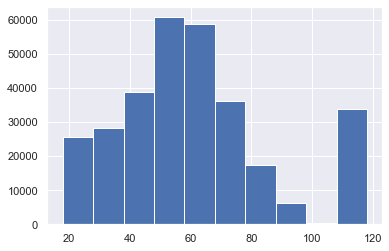

In [175]:
df['age'].hist();

--> Seems that there could a potential error in the data as more than 30.000 records older than 110 in the data set seems unrealistic.

In [176]:
df['customer_id'].nunique()

17000

In [177]:
df[df['age']>=110].age.count()

33772

In [178]:
df[df['age']>=110].customer_id.nunique()

2175

In [179]:
df[df['age']<=110].age.count()

272762

In [180]:
df[df['age']<=110].customer_id.nunique()

14825

--> There are 2175 unique customers older than 110 compared to 33772 records. Compared to the users younger than 110 there is a difference in the ratio from records and unique customers which could lead to the assumption that either customers older than 110 are quite active and receive a lot of offers or there is a error in the data. From my point of view it is difficult to decide but it is quite unrealistic so for a better analysis I will replace the values with an age over 100 with NaN.

In [181]:
df['age'] = df['age'].apply(lambda x: np.nan if x >= 110 else x)

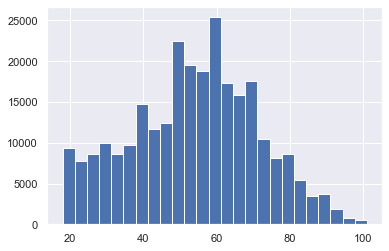

In [182]:
df['age'].hist(bins=25);

In [183]:
from datetime import date

In [184]:
# investigate how long members have been members
# create a new column with days of membership with regard to today
df['memberdays'] = date.today() - pd.to_datetime(df['became_member_on']).dt.date
df['memberdays'] = df['memberdays'].dt.days

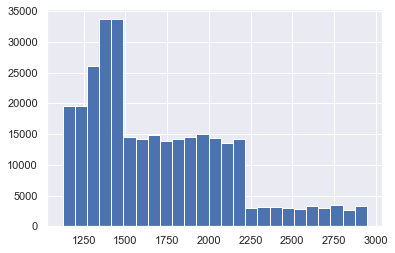

In [185]:
df['memberdays'].hist(bins=25);

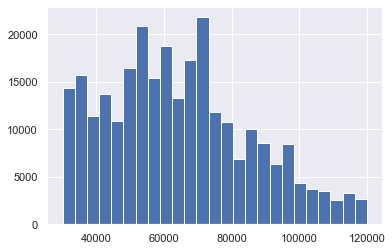

In [186]:
#explore the income variable
df['income'].hist(bins=25)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


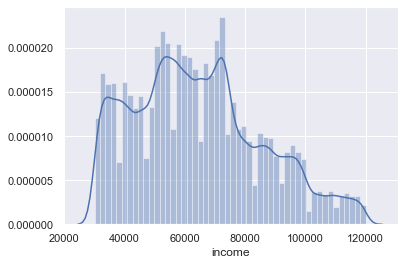

In [187]:
sns.distplot(df['income'], bins=50, hist_kws={'alpha': 0.4});

In [188]:
df['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

The numbers reveal that this data has to be carefully considered. Normally you would expect the following user journey. Once a user received an offer the user can view it in the next step. Afterwards the user can make a transactional action (click on it) and later on complete the offer. This user journey in mind would implicate the highest number of counts on offer received and decrease in the next steps. In this case it is possible that a user makes a transaction without even viewing or receiving the offer as the numbers indicate.
For further analysis this is important to consider as it determines the actions to take.

In [189]:
df['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

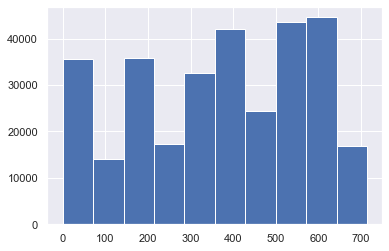

In [190]:
df['time'].hist()

It can be seen that not all users take actions in the same time frame. One possible reason could be that there are users that use the app frequently and respond in a shorter time frame, but that these users are also more likely to use the offer as they use the app more frequently. This needs further investigations.

In [191]:
df['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

(0, 60)

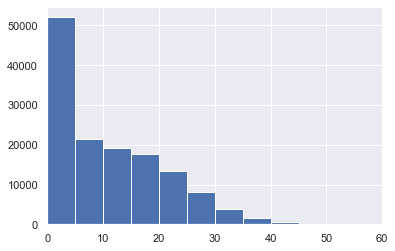

In [192]:
df['amount'].hist(bins=[0,5, 10,15, 20,25, 30,35, 40,45, 50,55, 60]);
plt.xlim(0,60)

Most purchases made are below 5 dollars. The amount spend constantly decreases in terms of frequency.

In [193]:
df['difficulty'].describe()

count    167581.000000
mean          7.850401
std           5.048944
min           0.000000
25%           5.000000
50%          10.000000
75%          10.000000
max          20.000000
Name: difficulty, dtype: float64

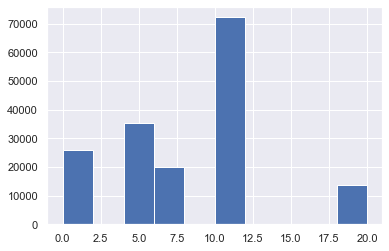

In [194]:
df['difficulty'].hist()

There is a clear spread in the difficulty of offers. 

In [195]:
df['reward'].describe()

count    167581.00000
mean          4.41991
std           3.37336
min           0.00000
25%           2.00000
50%           5.00000
75%           5.00000
max          10.00000
Name: reward, dtype: float64

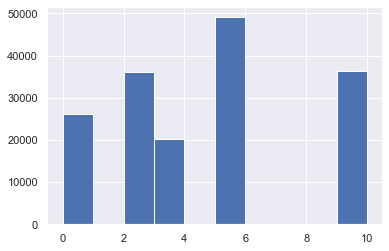

In [196]:
df['reward'].hist()

It seems that difficulty and reward have the same spread so the variables could depend on each other.

In [197]:
df['duration'].describe()

count    167581.000000
mean          6.610737
std           2.136130
min           3.000000
25%           5.000000
50%           7.000000
75%           7.000000
max          10.000000
Name: duration, dtype: float64

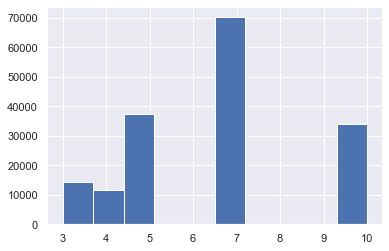

In [198]:
df['duration'].hist()

There is some variance in the duration variable which could be interesting for further investigation. Users that open the offer earlier might be using the app more frequently which could indicate that they already have a different purchasing behaviour. 

In [199]:
df['offer_type'].value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [200]:
df[df['email']>0].age.count()

148805

In [201]:
df[df['social']>0].age.count()

97960

In [202]:
df[df['mobile']>0].age.count()

136478

In [203]:
df[df['web']>0].age.count()

120048

There is some difference in which channel is used to promote the offer. It could a variable of interest for further information.

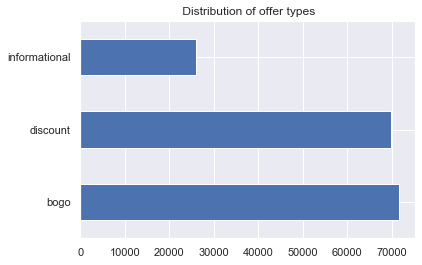

In [204]:
df['offer_type'].value_counts().plot.barh(title=' Distribution of offer types');

#### Conclusion
After the data is cleaned and explored it is time to ask the right questions in order to come up with insights that can be used to increase the performance of offers.

## Data Analysis

First, it is necessary to understand which value this analysis can bring to Starbucks. The objective from Starbucks is to send out offers as efficient as possible and target offer types and characteristica to certain user groups. In the end it is all about the money a user spends by using an offer. So this analysis focuses on descriptive and advanced statistical analysis to investigate which differences in the data can be observed and which variables play together. To do it in a structured way I will answer the following questions:

- Does user characateristica (age, gender, days of membership, income) influence how users use the offers? 
- Are there channels that are more effective than others or can be related to a special group of users?
- Does the offer type play a crucial role in how users act on the offer?

With this questions answered, Starbucks could roll out there new offer strategy with a more targeted approach to increase the effectiveness.

#### Does user characateristica (age, gender, days of membership, income) influence how users use the offers?

In [205]:
male_total = df[(df['gender']=='M')].gender.count()
female_total = df[(df['gender']=='F')].gender.count()
nongender_total = df[(df['gender']=='O')].gender.count()
total = df.shape[0]

In [206]:
total

306534

In [207]:
rel_m_or = df[(df['offer-received']==1)&(df['gender']=='M')].gender.count() / total
rel_f_or = df[(df['offer-received']==1)&(df['gender']=='F')].gender.count() / total
rel_o_or = df[(df['offer-received']==1)&(df['gender']=='O')].gender.count() / total

rel_m_ov = df[(df['offer-viewed']==1)&(df['gender']=='M')].gender.count() / total
rel_f_ov = df[(df['offer-viewed']==1)&(df['gender']=='F')].gender.count() / total
rel_o_ov = df[(df['offer-viewed']==1)&(df['gender']=='O')].gender.count() / total

rel_m_t = df[(df['transaction']==1)&(df['gender']=='M')].gender.count() / total
rel_f_t = df[(df['transaction']==1)&(df['gender']=='F')].gender.count() / total
rel_o_t = df[(df['transaction']==1)&(df['gender']=='O')].gender.count() / total

rel_m_oc = df[(df['offer-completed']==1)&(df['gender']=='M')].gender.count() / total
rel_f_oc = df[(df['offer-completed']==1)&(df['gender']=='F')].gender.count() / total
rel_o_oc = df[(df['offer-completed']==1)&(df['gender']=='O')].gender.count() / total

In [208]:
male_values = [rel_m_or, rel_m_ov, rel_m_t, rel_m_oc]
female_values = [rel_f_or, rel_f_ov, rel_f_t, rel_f_oc]
o_values = [rel_o_or, rel_o_ov, rel_o_t, rel_o_oc]

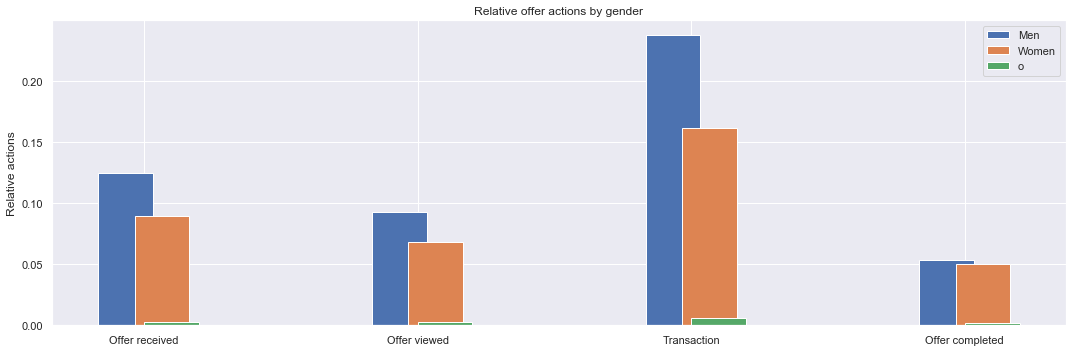

In [209]:
labels = ['Offer received', 'Offer viewed', 'Transaction', 'Offer completed']
#male_values = [0.5733597991007654 , 0.5676093060569595 , 0.5872520309462153 , 0.5075206509678215]
#female_values = [0.4128659719402716  ,0.4168872843963097  ,0.3983800834160233 , 0.47703735667611885 ]
#o_values = [0.013774228958963023, 0.015503409546730846, 0.014367885637761481 , 0.015441992356059671]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/3, male_values, width, label='Men')
rects2 = ax.bar(x + width/3, female_values, width, label='Women')
rects3 = ax.bar(x + width/2, o_values, width, label='o')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative actions')
ax.set_title('Relative offer actions by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout();

plt.show();

In [210]:
rel_diff_or = rel_f_or / rel_m_or
rel_diff_ov = rel_f_ov / rel_m_ov
rel_diff_t  = rel_f_t / rel_m_t
rel_diff_oc = rel_f_oc / rel_m_oc
print(rel_diff_or, rel_diff_ov, rel_diff_t, rel_diff_oc)

0.7200818274803955 0.7344616797993004 0.6783800862708464 0.9399368395481598


Analysing how the user grouped by gender proceed in the steps / events shows that in a relative way, more men than women are getting an offer. This ration stays about the same until the step offer completed. Compared to the total numbers of records it can be seen that men and women have almost the same ratio in completing an offer which shows, compared to an existing difference before, that women are more likely to complete an offer.

The same can be seen when looking at absolute numbers. More men than women receiving an offer but women have almost the same amount of offer completions. This could be also due to women per se are just more using the app so it is important to see how many offers completed did not receive an offer.

Text(0, 0.5, '$')

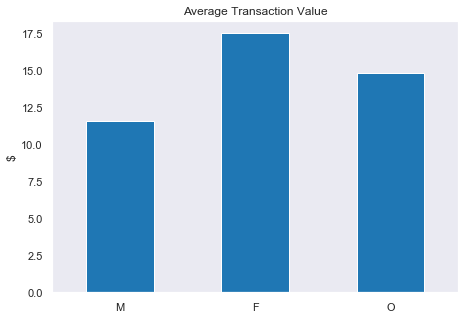

In [211]:
plt.figure(figsize=(16,5))

plt.subplot(121)
gender_groupby = df.groupby('gender')
gender_transacts = gender_groupby.transaction.sum()
gender_expense = gender_groupby.amount.sum()
(gender_expense / gender_transacts).reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

To support this implications we can also see that women have a higher average transaction value which makes them a more valuable customer source.

In [212]:
df.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income', 'event',
       'time', 'offer-completed', 'offer-received', 'offer-viewed',
       'transaction', 'offer_id', 'amount', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'memberdays'],
      dtype='object')

In [213]:
df[df['offer-received']==1].age.count()

66501

In [214]:
df[df['offer-viewed']==1].age.count()

49860

In [215]:
df[df['transaction']==1].age.count()

123957

In [216]:
df[df['offer-completed']==1].age.count()

32444

Following the logic of user steps and a decreasing number in every step, the data in transaction is not as we would expect it. The other data flow can be seen as steps in a user journey when receiving an offer. So for further analysis we will neglect the transation column.

In [217]:
df.age.mean()

53.840696284673086

In [218]:
df[df['offer-received']==1].age.mean()

54.369257605148796

In [219]:
df[df['offer-viewed']==1].age.mean()

54.644645006016844

In [220]:
df[df['offer-completed']==1].age.mean()

55.826624337319686

It tends the older a user gets the more users will complete an offer.

In [221]:
df[df['offer-received']==1].income.mean()

65371.61847190268

In [222]:
df[df['offer-viewed']==1].income.mean()

65841.59647011633

In [223]:
df[df['offer-completed']==1].income.mean()

69430.80384662804

For the income variable it can be observed a similar tendency that the income mean is higher from offer completion events compared to offer received and viewed.

Let's take a look if the data changes when we split the date into male, female and others.

In [224]:
df.groupby('gender').age.mean()

gender
F    56.735564
M    51.730580
O    54.120625
Name: age, dtype: float64

In [225]:
df[df['offer-received']==1].groupby('gender').age.mean()

gender
F    57.469806
M    52.127987
O    54.728166
Name: age, dtype: float64

In [226]:
df[df['offer-viewed']==1].groupby('gender').age.mean()

gender
F    57.452179
M    52.564609
O    55.304010
Name: age, dtype: float64

In [227]:
df[df['offer-completed']==1].groupby('gender').age.mean()

gender
F    57.972605
M    53.819507
O    55.499002
Name: age, dtype: float64

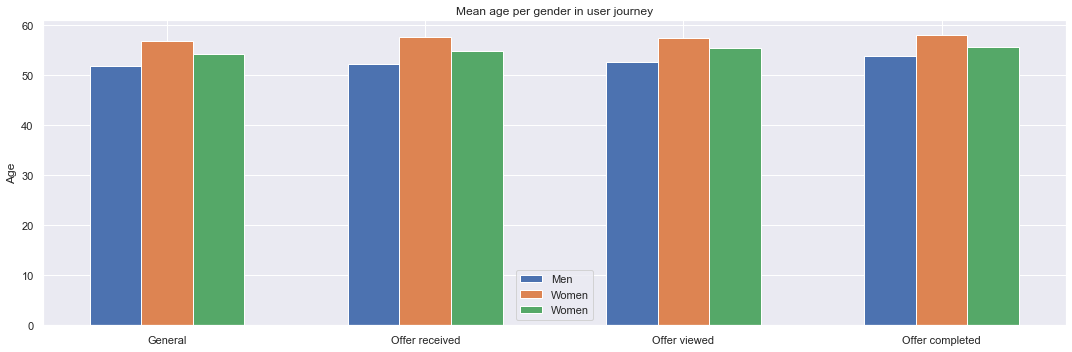

In [228]:

labels = ['General','Offer received', 'Offer viewed', 'Offer completed']
men_means = [df.groupby('gender').age.mean()[1], df[df['offer-received']==1].groupby('gender').age.mean()[1], df[df['offer-viewed']==1].groupby('gender').age.mean()[1], df[df['offer-completed']==1].groupby('gender').age.mean()[1]]
women_means = [df.groupby('gender').age.mean()[0], df[df['offer-received']==1].groupby('gender').age.mean()[0], df[df['offer-viewed']==1].groupby('gender').age.mean()[0], df[df['offer-completed']==1].groupby('gender').age.mean()[0]]
other_means = [df.groupby('gender').age.mean()[2], df[df['offer-received']==1].groupby('gender').age.mean()[2], df[df['offer-viewed']==1].groupby('gender').age.mean()[2], df[df['offer-completed']==1].groupby('gender').age.mean()[2]]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - 0.2, men_means, width, label='Men')
rects2 = ax.bar(x + 0, women_means, width, label='Women')
rects3 = ax.bar(x + 0.2, other_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Age')
ax.set_title('Mean age per gender in user journey')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [229]:
df.groupby('gender').income.mean()

gender
F    69546.750250
M    60589.087289
O    62897.758751
Name: income, dtype: float64

In [230]:
df[df['offer-received']==1].groupby('gender').income.mean()

gender
F    71238.599942
M    61199.979019
O    63162.663755
Name: income, dtype: float64

In [231]:
df[df['offer-viewed']==1].groupby('gender').income.mean()

gender
F    70999.855672
M    62065.333380
O    65391.979301
Name: income, dtype: float64

In [232]:
df[df['offer-completed']==1].groupby('gender').income.mean()

gender
F    73313.303612
M    65911.150249
O    65169.660679
Name: income, dtype: float64

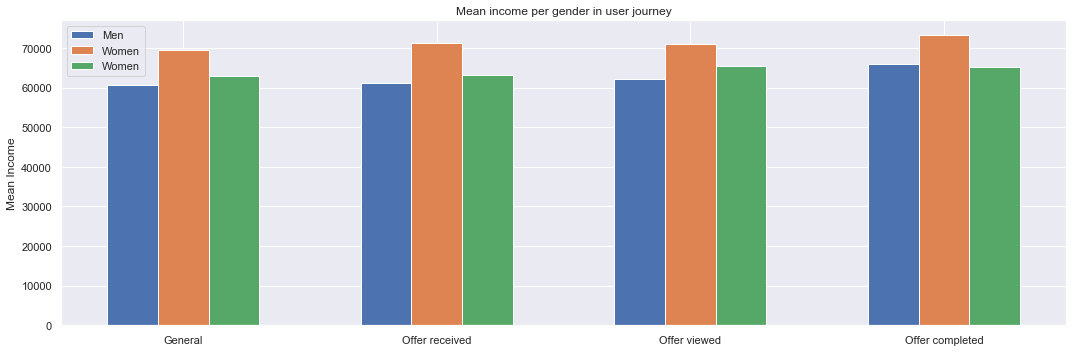

In [233]:

labels = ['General','Offer received', 'Offer viewed', 'Offer completed']
men_means = [df.groupby('gender').income.mean()[1], df[df['offer-received']==1].groupby('gender').income.mean()[1], df[df['offer-viewed']==1].groupby('gender').income.mean()[1], df[df['offer-completed']==1].groupby('gender').income.mean()[1]]
women_means = [df.groupby('gender').income.mean()[0], df[df['offer-received']==1].groupby('gender').income.mean()[0], df[df['offer-viewed']==1].groupby('gender').income.mean()[0], df[df['offer-completed']==1].groupby('gender').income.mean()[0]]
other_means = [df.groupby('gender').income.mean()[2], df[df['offer-received']==1].groupby('gender').income.mean()[2], df[df['offer-viewed']==1].groupby('gender').income.mean()[2], df[df['offer-completed']==1].groupby('gender').income.mean()[2]]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - 0.2, men_means, width, label='Men')
rects2 = ax.bar(x + 0, women_means, width, label='Women')
rects3 = ax.bar(x + 0.2, other_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Income')
ax.set_title('Mean income per gender in user journey')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

##### Conclusion
Taking user characteristics into account first it seems that the mean age increases independently in every user step. Taking a closer look at the dependancy on the gender variable shows that age only shows a small difference. Looking at the income variable there is an observable change during the offer completion step where the income of male and female is higher than in the other steps. Especially for men there is a 8 - 9% increase in income.
This implies that income could be a good variable to target the offer strategy.

#### Are there channels that are more effective than others or can be related to a special group of users?

In [234]:
completion_ratio_email = df[(df['offer-completed']==1)&(df['email']==1)].customer_id.count() / df[(df['offer-received']==1)&(df['email']==1)].customer_id.count()
completion_ratio_social = df[(df['offer-completed']==1)&(df['social']==1)].customer_id.count() / df[(df['offer-received']==1)&(df['social']==1)].customer_id.count()
completion_ratio_mobile = df[(df['offer-completed']==1)&(df['mobile']==1)].customer_id.count() / df[(df['offer-received']==1)&(df['mobile']==1)].customer_id.count()
completion_ratio_web = df[(df['offer-completed']==1)&(df['web']==1)].customer_id.count() / df[(df['offer-received']==1)&(df['web']==1)].customer_id.count()

In [235]:
print(completion_ratio_email, completion_ratio_social, completion_ratio_mobile, completion_ratio_web)

0.4402244451145168 0.4769389050631526 0.4395778979434185 0.49000836051868


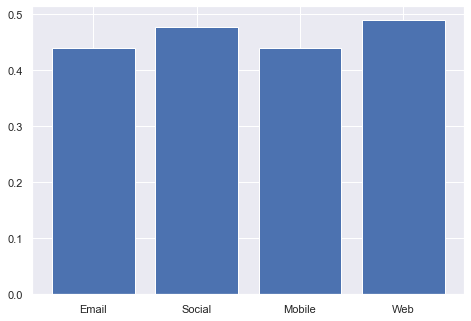

In [236]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Email', 'Social', 'Mobile', 'Web']
completion_rates = [completion_ratio_email, completion_ratio_social, completion_ratio_mobile, completion_ratio_web]
ax.bar(labels,completion_rates)
plt.show()

It can be seen that Social and Web have higher completion rates than the Email and Mobile when taking the events offers received and completed into account.

In [237]:
df[(df['offer-received']==1)&(df['email']==1)].age.mean()

54.369257605148796

In [238]:
df[(df['offer-completed']==1)&(df['email']==1)].age.mean()

55.826624337319686

In [239]:
df[(df['offer-received']==1)&(df['social']==1)].age.mean()

54.36538364906286

In [240]:
df[(df['offer-completed']==1)&(df['social']==1)].age.mean()

55.73930053914786

In [241]:
df[(df['offer-received']==1)&(df['mobile']==1)].age.mean()

54.36786281890422

In [242]:
df[(df['offer-completed']==1)&(df['mobile']==1)].age.mean()

55.72861174203317

In [243]:
df[(df['offer-received']==1)&(df['web']==1)].age.mean()

54.36693935119887

In [244]:
df[(df['offer-completed']==1)&(df['web']==1)].age.mean()

55.72904436030152

In all of the channels used it seems that older users tend to have a higher completion rate. Looking at different channels there can be no completion rate difference observed depending on the age of users.

In [245]:
df[(df['offer-received']==1)&(df['email']==1)].income.mean()

65371.61847190268

In [246]:
df[(df['offer-completed']==1)&(df['email']==1)].income.mean()

69430.80384662804

In [247]:
df[(df['offer-received']==1)&(df['social']==1)].income.mean()

65456.107733279736

In [248]:
df[(df['offer-completed']==1)&(df['social']==1)].income.mean()

69218.23560284365

In [249]:
df[(df['offer-received']==1)&(df['mobile']==1)].income.mean()

65393.22459222083

In [250]:
df[(df['offer-completed']==1)&(df['mobile']==1)].income.mean()

69145.84623855737

In [251]:
df[(df['offer-received']==1)&(df['web']==1)].income.mean()

65323.196991067234

In [252]:
df[(df['offer-completed']==1)&(df['web']==1)].income.mean()

69081.7730225449

For income hte same is observed. This could also be because of the random selection of the experiment so no user groups are more presented than another in one special channel.

##### Conclusion
There are some channels that perform better than others. In this data especially the channel web and to some extend social have higher completion rates. For further strategies it could be a good starting point to focus on this channels.

#### Does the offer type play a crucial role in how users act on the offer?

In [253]:
df[df['offer-received']==1].groupby('offer_type').gender.value_counts()

offer_type     gender
bogo           M         15208
               F         10975
               O           354
discount       M         15354
               F         10943
               O           367
informational  M          7567
               F          5538
               O           195
Name: gender, dtype: int64

In [254]:
df[df['offer-completed']==1].groupby('offer_type').gender.value_counts()

offer_type  gender
bogo        M         7512
            F         7501
            O          245
discount    M         8954
            F         7976
            O          256
Name: gender, dtype: int64

We see that male receive more offers than females in absolute terms but they have about the same numbers of offers completion which implies that women have a much higher completion rate depending on the offer types. Discounts have a small advantage compared to bogo.

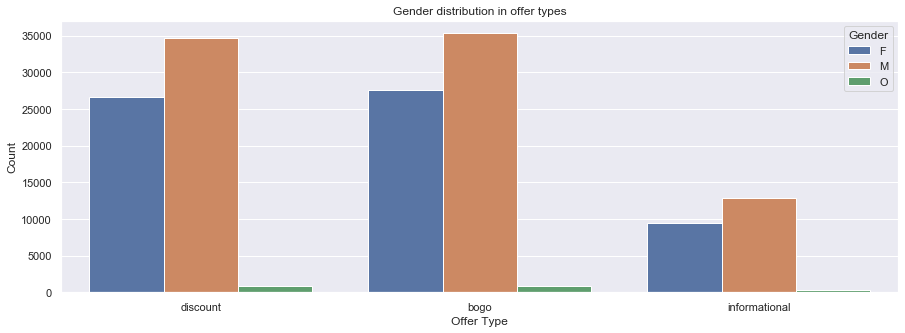

In [255]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=df)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

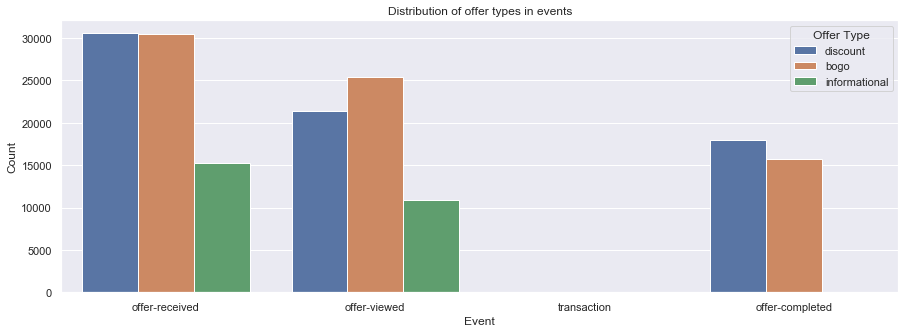

In [256]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

##### Conclusion
This graph shows that there are about the same amount of offer types getting send to users. Looking at the user journey it first seems that bogos are more effective as they get seen more times. Looking at which offer types leads to offer completion clearly states that discounts lead to more offer completion and therefore are more effective.

## Conclusion
To see the bigger picture it was necessary to deep dive into the data and into single steps. For me starting point of the analysis was to see if the user journey from receiving an offer to viewing and completing it has some special characteristics to inform further offer strategies.

Looking at a user level it can be seen that women tend to be a more lucrative source for Starbucks as they tend to have a higher completion rate of the offers and also have a higher average transaction value. Also income seems to increase for the users that complete an offer. Interestingly men have a slightly higher increase which could make men with a higher income a potential target for new offers.

In general it can be said that the web channel has the best performance in completion rate follwed by social. Also interestingly there can be no differences be detected in user characteristics which leads me to the implication that the web channel just has a better performance.

In the end looking at the offer types discount have a better performance than bogo which could Starbucks lead to the implication that for further strategies discounts are the most effective way when it comes down to offer completion ratio.

To sum up, to increase the offer effectiveness Starbucks could focus on female users using the web channel and offering more discounts.